# package import

In [1]:
import sys
import time

import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
sys.path.append('../')
from model.pmm import Poisson_Mixture_with_Dirichlet_Gamma_prior

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# comparison with PyMC

In [2]:
N = 3000 # the number of data
S = 500 # the number of Gibbs Sample
np.random.seed(100) # fix seed
X = np.random.poisson([3,20],(N,2))
y = np.random.multinomial(1,[0.1,0.9],N) # true hidden compnent
data = (X*y).sum(1) # Poisson Mixture sample

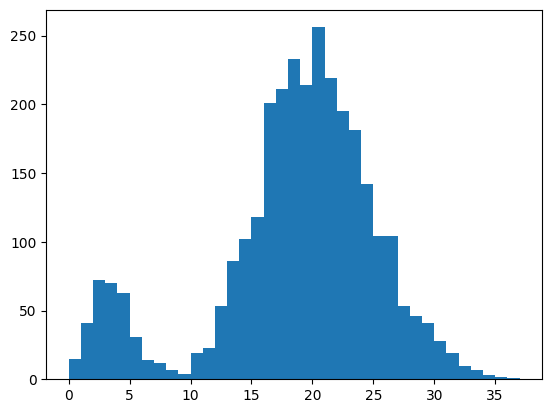

In [3]:
plt.hist(data,np.linspace(0,data.max(),data.max()+1));

In [4]:
cent = np.array([0.1,10]) # cent hyper parameter of Dirichlet prior
shape = np.array([[1,],[1,],]) # shape hyper parameter of Gamma prior
scale = np.array([[1,],[1,],]) # scale hyper parameter of Gamma prior

In [5]:
# PyMC
with pm.Model() as model:
    w = pm.Dirichlet('w', a=cent)  # 2 mixture weights

    lam1 = pm.Gamma('lam1', shape[0,0], scale[0,0])
    lam2 = pm.Gamma('lam2', shape[1,0], scale[1,0])

    # As we just need the logp, rather than add a RV to the model, we need to call `.dist()`
    # These two forms are equivalent, but the second benefits from vectorization
    components = [
        pm.Poisson.dist(mu=lam1),
        pm.Poisson.dist(mu=lam2),
    ]
    # `shape=(2,)` indicates 2 mixture components
    components = pm.Poisson.dist(mu=pm.math.stack([lam1, lam2]), shape=(2,))

    like = pm.Mixture('like', w=w, comp_dists=components, observed=data)

    # MCMC
    with model:
        st = time.time()
        trace = pm.sample(S,tune=5*N)
        ed = time.time()
        print(f'Elapsed time: {ed-st} sec.')

# show result
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, lam1, lam2]


Sampling 4 chains for 15_000 tune and 500 draw iterations (60_000 + 2_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Elapsed time: 20.690408945083618 sec.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.302,0.340,0.096,0.896,0.168,0.129,7.0,34.0,1.53
w[1],0.698,0.340,0.104,0.904,0.168,0.129,7.0,34.0,1.53
lam1,7.302,7.310,2.910,20.049,3.625,2.774,7.0,29.0,1.53
lam2,15.741,7.307,2.986,20.124,3.624,2.773,7.0,31.0,1.53


In [6]:
original = Poisson_Mixture_with_Dirichlet_Gamma_prior(data[:,np.newaxis])

In [7]:
original.set_model(2, cent=cent, shape=shape, scale=scale, L = 4)

In [8]:
st = time.time()
gs = original.GibbsSampling(S,burnin=5*N)
ed = time.time()
print(f'Elapsed time: {ed-st} sec.')

burn-in...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:01<00:00, 13227.96it/s]


sampling...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12461.09it/s]

Elapsed time: 1.1852920055389404 sec.


In [9]:
gs[0].mean(0),gs[1].mean(0)

(array([[0.89035443, 0.10964557],
        [0.89046925, 0.10953075],
        [0.10617295, 0.89382705],
        [0.10620037, 0.89379963]]),
 array([[[19.96010919],
         [ 3.09128559]],
 
        [[19.95504838],
         [ 3.08229848]],
 
        [[ 3.07482782],
         [19.95744353]],
 
        [[ 3.07935363],
         [19.95443316]]]))